In [195]:
from numpy import *
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

grid = xr.open_dataset('/Users/Ethan/Documents/Research/2016-08 - UW/Data/SOSE/grid.nc')
sic = xr.open_dataset('/Users/Ethan/Documents/Research/2016-08 - UW/Data/SOSE/bsose_i105_2008to2012_monthly_SeaIceArea.nc')
ncp = xr.open_dataset('/Users/Ethan/Documents/Research/2016-08 - UW/Data/SOSE/bsose_i105_2008to2012_monthly_NCP.nc')

In [168]:
# define Weddell SIZ as all grid cells south of 48°S and between 60°W and 20°E featuring seasonal sea ice presence
weddell_mask = logical_and(grid['YC'] < -48,logical_or(grid['XC'] > 300,grid['XC'] < 20))
siz_mask = logical_and(sic['SIarea'].max(dim='time') > 0.0,sic['SIarea'].min(dim='time') < 0.15)
weddell_siz_mask = logical_and(weddell_mask,siz_mask.values)

# define Maud Rise region as 63°-67°S, 0°-10°E, per Campbell et al. 2019
mr_mask = logical_and(logical_and(grid['YC'] <= -63,grid['YC'] >= -67),logical_and(grid['XC'] >= 0,grid['XC'] <= 10))

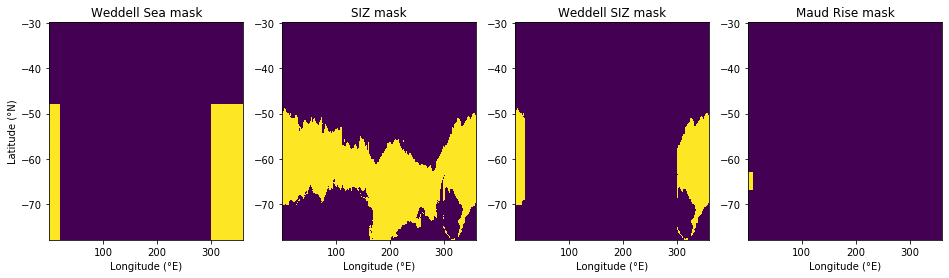

In [169]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.pcolormesh(grid['XC'],grid['YC'],weddell_mask); plt.title('Weddell Sea mask'); plt.xlabel('Longitude (°E)'); plt.ylabel('Latitude (°N)');
plt.subplot(1,4,2)
plt.pcolormesh(grid['XC'],grid['YC'],siz_mask); plt.title('SIZ mask'); plt.xlabel('Longitude (°E)');
plt.subplot(1,4,3)
plt.pcolormesh(grid['XC'],grid['YC'],weddell_siz_mask); plt.title('Weddell SIZ mask'); plt.xlabel('Longitude (°E)');
plt.subplot(1,4,4)
plt.pcolormesh(grid['XC'],grid['YC'],mr_mask); plt.title('Maud Rise mask'); plt.xlabel('Longitude (°E)');

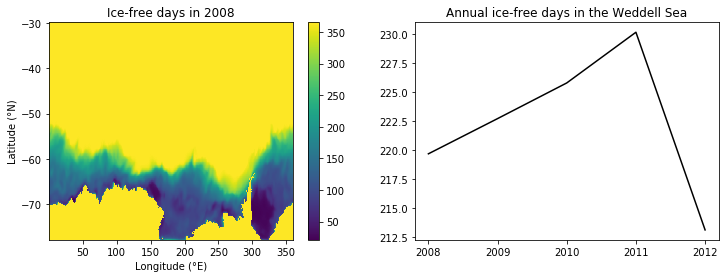

In [170]:
# calculate annual ice-free season length
# note: this is an approximation that assumes SIC is usually close to 0% or 100%, so (1 - monthly average SIC) can
#       be scaled to reasonably estimate ice-free days
annual_ice_free_days = 365.24/12 * (12 - sic['SIarea'].groupby('time.year',restore_coord_dims=True).sum())
annual_ice_free_days_weddell = pd.Series(index=annual_ice_free_days.year.values,
                                         data=[average(annual_ice_free_days.sel(year=year).values[weddell_siz_mask],
                                                       weights=sic['rA'].values[weddell_siz_mask])
                                               for year in annual_ice_free_days.year],
                                         dtype=float64)

# example plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.pcolormesh(grid['XC'],grid['YC'],annual_ice_free_days.sel(year=2008))
plt.title('Ice-free days in 2008'); plt.xlabel('Longitude (°E)'); plt.ylabel('Latitude (°N)'); plt.colorbar();
plt.subplot(1,2,2)
plt.plot(annual_ice_free_days_weddell,c='k')
plt.xticks(annual_ice_free_days.year.values)
plt.title('Annual ice-free days in the Weddell Sea');

In [171]:
# compute depth-integrated NCP, taking into account vertical grid cell size
# note: assume NCP is negligible below 500 m
ncp_column = (ncp['BLGNCP'] * ncp['drF']).sel(Z=slice(0,-500)).sum(dim='Z')
ncp_column.attrs['units'] = 'mol C/m2/s'
ncp_column.attrs['long_name'] = 'Net Community Production'

In [172]:
# compute ANCP
ancp_column = ncp_column.groupby('time.year',restore_coord_dims=True).sum() * 60 * 60 * 24 * 365.24
ancp_column.attrs['units'] = 'mol C/m2'
ancp_column_weddell = pd.Series(index=ancp_column.year.values,
                                data=[sum((ancp_column * ancp_column['rA']).sel(year=year).values[weddell_siz_mask]) 
                                      / sum(ancp_column['rA'].values[weddell_siz_mask]) 
                                      for year in ancp_column.year],
                                dtype=float64)
ancp_column_weddell.attrs['units'] = 'mol C/m2'

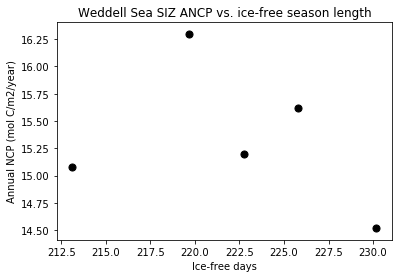

In [193]:
# compare ANCP and ice-free season length
plt.figure(figsize=(6,4))
plt.scatter(annual_ice_free_days_weddell,ancp_column_weddell,c='k',s=50)
plt.xlabel('Ice-free days'); plt.ylabel('Annual NCP (mol C/m2/year)'); plt.title('Weddell Sea SIZ ANCP vs. ice-free season length');

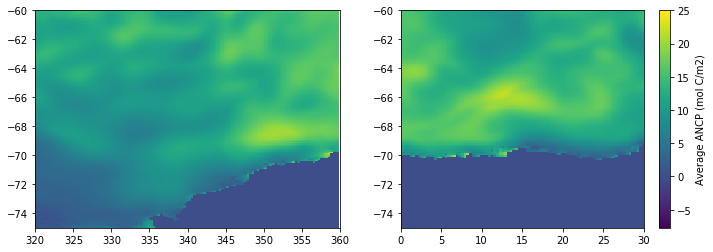

In [151]:
# see if Maud Rise has an imprint in ANCP in B-SOSE
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.pcolormesh(grid['XC'],grid['YC'],ancp_column.mean(dim='year'),vmax=25); plt.xlim([320,360]); plt.ylim([-75,-60]);
plt.subplot(1,2,2)
plt.pcolormesh(grid['XC'],grid['YC'],ancp_column.mean(dim='year'),vmax=25); plt.xlim([0,30]); plt.ylim([-75,-60]);
cbar = plt.colorbar();
cbar.set_label('Average ANCP (mol C/m2)')

In [194]:
# calculate statistics for Maud Rise vs. entire Weddell Sea
mr_average_ancp = average(ancp_column.mean(dim='year').values[mr_mask],    # units: mol C/m2
                          weights=ancp_column['rA'].values[mr_mask])
weddell_average_ancp = average(ancp_column.mean(dim='year').values[weddell_siz_mask],
                               weights=ancp_column['rA'].values[weddell_siz_mask])
mr_total_ancp = sum((ancp_column * ancp_column['rA']).mean(dim='year').values[mr_mask])  # units: mol C
weddell_total_ancp = sum((ancp_column * ancp_column['rA']).mean(dim='year').values[weddell_siz_mask])
mr_total_area = sum(ancp_column['rA'].values[mr_mask])  # units: m2
weddell_total_area = sum(ancp_column['rA'].values[weddell_siz_mask])  # units: m2

print('Note: statistics are averages over B-SOSE period of 2008-2011\n')
print('Average ANCP within Maud Rise region: {0:.2f} mol C/m2'.format(mr_average_ancp))
print('Average ANCP within Weddell Sea SIZ: {0:.2f} mol C/m2'.format(weddell_average_ancp))
print('Total ANCP within Maud Rise region: {0:.2f} Tmol C'.format(mr_total_ancp/1e12))
print('Total ANCP within Weddell Sea SIZ: {0:.2f} Tmol C'.format(weddell_total_ancp/1e12))
print('Contribution of Maud Rise region to Weddell Sea ANCP: {0:.2f}%'.format(100*mr_total_ancp/weddell_total_ancp))
print('Contribution of Maud Rise region to Weddell Sea SIZ area: {0:.2f}%'.format(100*mr_total_area/weddell_total_area))

Note: statistics are averages over B-SOSE period of 2008-2011

Average ANCP within Maud Rise region: 14.73 mol C/m2
Average ANCP within Weddell Sea SIZ: 15.34 mol C/m2
Total ANCP within Maud Rise region: 3.04 Tmol C
Total ANCP within Weddell Sea SIZ: 132.23 Tmol C
Contribution of Maud Rise region to Weddell Sea ANCP: 2.30%
Contribution of Maud Rise region to Weddell Sea SIZ area: 2.39%
